# Tópicos Avançados de Ciência de Dados -  Project 

Bárbara Nóbrega Galiza – 202408654​

Cláudia Oliveira - 202005668​

Marta Campos - 202008344

In this document, we will be using machine learning models and apply them to the dataset we created using R

Importing libraries

In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

Reading the tables

In [4]:
df = pd.read_csv('tables/task1.csv')

df.drop('tweet', axis=1, inplace= True)  

df['final_label'] = df['final_label'].map({'NO': 0, 'YES': 1})

This is the function we'll be using to get the evaluation metrics for each of our models

In [5]:
def evaluation(y,y_pred):
    # Scores
    print("classification report: \n", classification_report(y,y_pred))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
    # Confusion Matrix
    sns.heatmap(confusion_matrix(y, y_pred), 
            annot=True, fmt="d", cmap="Blues", cbar=False, square=True, ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    auc_score = roc_auc_score(y, y_pred)

    axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color="blue")
    axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
    axes[1].set_title("Receiver Operating Characteristic (ROC) Curve")
    axes[1].set_xlabel("False Positive Rate (FPR)")
    axes[1].set_ylabel("True Positive Rate (TPR)")
    axes[1].legend(loc="lower right")
    axes[1].grid()

    plt.tight_layout()
    plt.show()

In [6]:
df.columns

Index(['final_label', 'woman', 'women', 'men', 'girl', 'sex', 'bitch', 'fuck',
       'love', 'peopl', 'gender', 'colloc_yes', 'colloc_no', 'all_pos',
       'all_neg', 'tweet_sentiment', 'sadness', 'sent_min', 'disgust_max'],
      dtype='object')

We will test 4 different models to chose our baseline model. This models will be applied to the dataset created using dfm and the dataset created using tfidf to test which model is better and using which dataset

In [7]:
X1 = df.drop('final_label', axis=1)  
y1 = df['final_label'] 

The features will be scaled to ensure that no single feature dominates the learning process due to differences in scale

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Decision Trees 

classification report: 
               precision    recall  f1-score   support

           0       0.72      0.73      0.72      1733
           1       0.58      0.56      0.57      1137

    accuracy                           0.66      2870
   macro avg       0.65      0.65      0.65      2870
weighted avg       0.66      0.66      0.66      2870



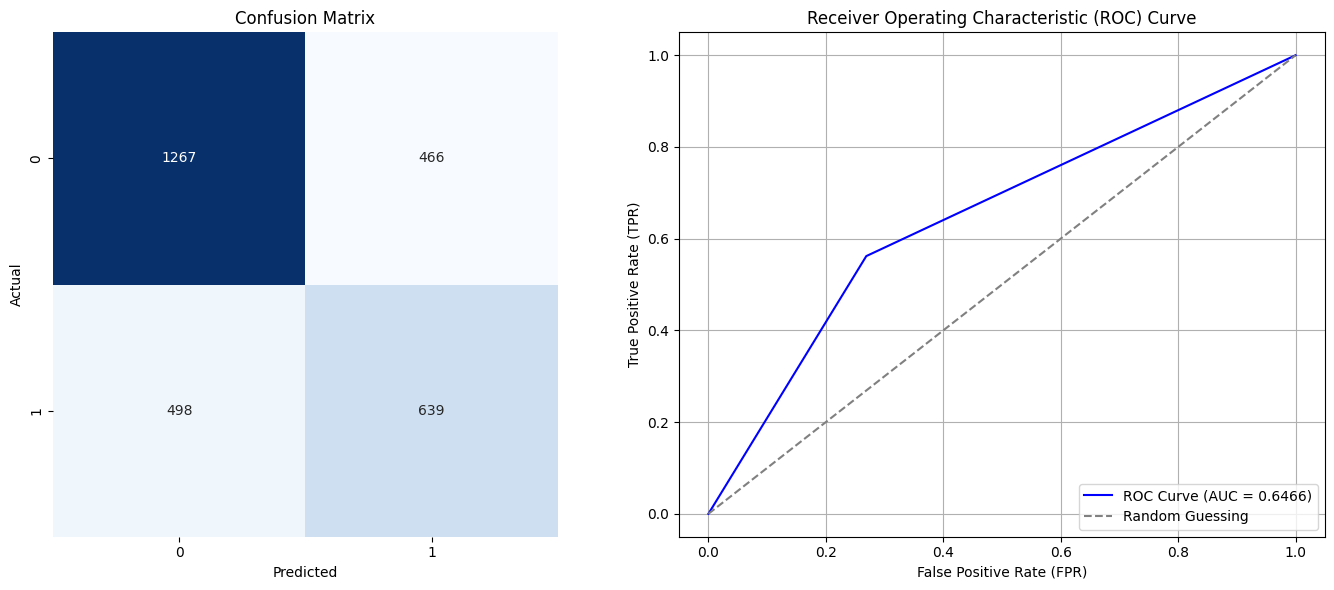

In [9]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

y_pred1 = cross_val_predict(pipeline, X1, y1, cv=skf)

evaluation(y1, y_pred1)

### SVM

classification report: 
               precision    recall  f1-score   support

           0       0.78      0.81      0.79      1733
           1       0.69      0.65      0.67      1137

    accuracy                           0.75      2870
   macro avg       0.74      0.73      0.73      2870
weighted avg       0.75      0.75      0.75      2870



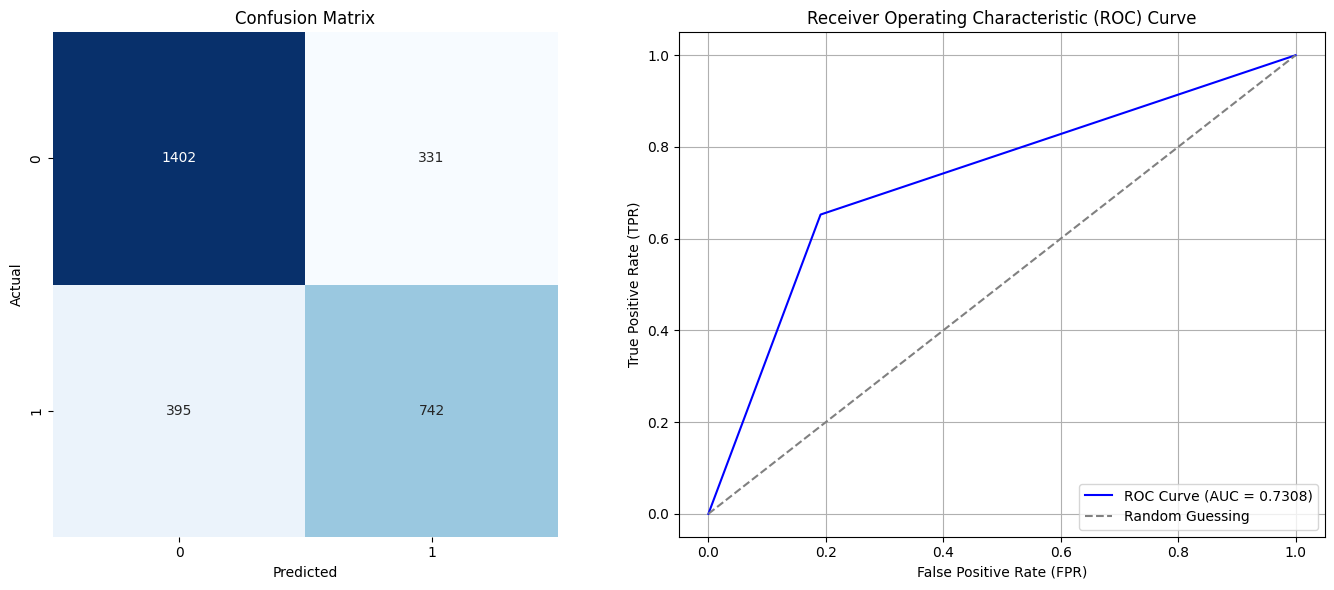

In [10]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', SVC(random_state=42))
])

y_pred1 = cross_val_predict(pipeline, X1, y1, cv=skf)

evaluation(y1, y_pred1)

### XGBoost

classification report: 
               precision    recall  f1-score   support

           0       0.76      0.78      0.77      1733
           1       0.64      0.62      0.63      1137

    accuracy                           0.71      2870
   macro avg       0.70      0.70      0.70      2870
weighted avg       0.71      0.71      0.71      2870



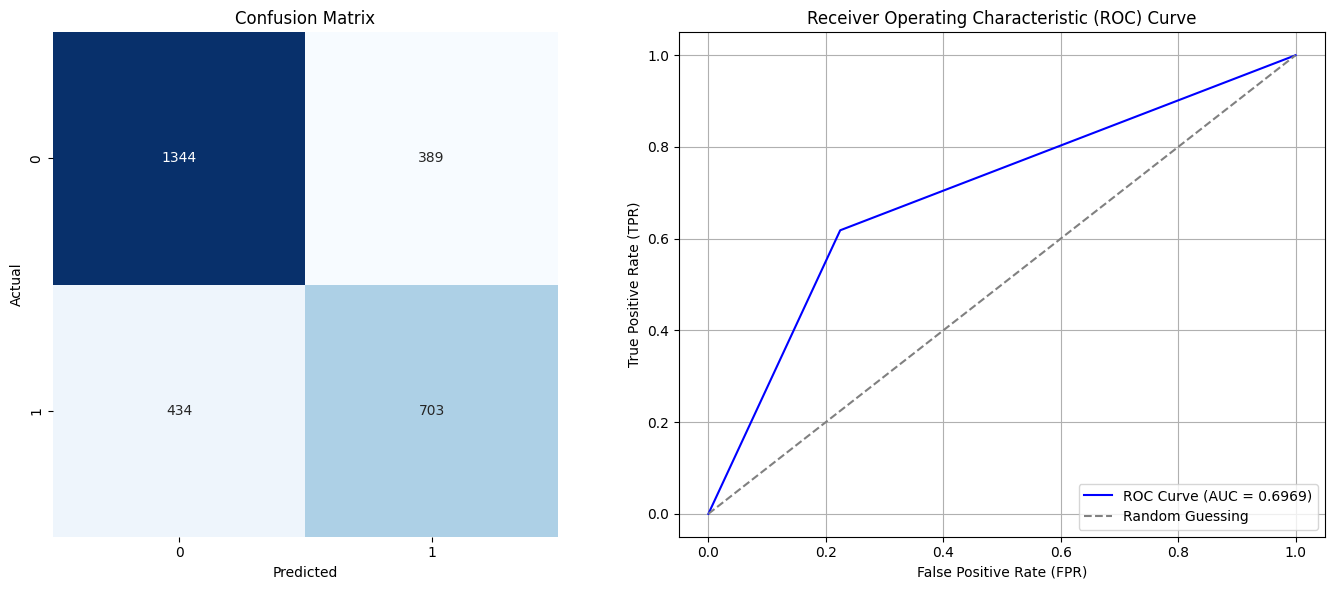

In [11]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(random_state=42, n_jobs=-1))
])

y_pred1 = cross_val_predict(pipeline, X1, y1, cv=skf)

evaluation(y1, y_pred1)

### Random Forest

classification report: 
               precision    recall  f1-score   support

           0       0.75      0.77      0.76      1733
           1       0.64      0.62      0.63      1137

    accuracy                           0.71      2870
   macro avg       0.70      0.70      0.70      2870
weighted avg       0.71      0.71      0.71      2870



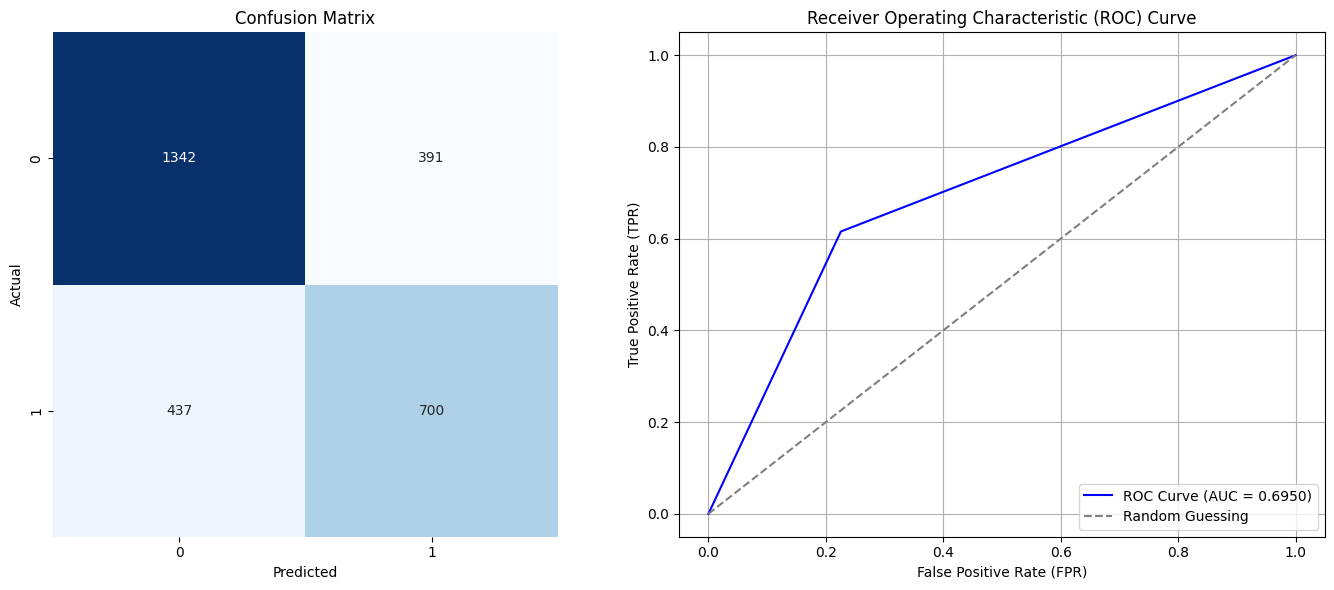

In [12]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

y_pred1 = cross_val_predict(pipeline, X1, y1, cv=skf)

evaluation(y1, y_pred1)

From the results shown above, we decided to use SVM since it was the one whose overall metrics were better

In this part, we will proceed to tune the chosen model using dev_labeled.csv

## SVM Tuning

Funtion to find the best parameters based on accuracy:

In [16]:
def acc(X_train, y_train, X_val, y_val, evaluation):

    accuracy_scorer = make_scorer(accuracy_score)

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('clf', SVC(random_state=42, kernel="rbf"))
    ])

    param_dist = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': [0.001, 0.01, 0.1, 1],
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_dist,
        scoring=accuracy_scorer,
        cv=skf,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)

    y_pred = grid_search.best_estimator_.predict(X_val)
    evaluation(y_val, y_pred)

Funtion to find the best parameters based on F1 of cases where a tweet was labeled as sexist:

In [17]:
def f1(X_train, y_train, X_val, y_val, evaluation):

    f1_class1 = make_scorer(f1_score, pos_label=1)

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('clf', SVC(random_state=42, kernel="rbf"))
    ])

    param_dist = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': [0.001, 0.01, 0.1, 1],
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_dist,
        scoring=f1_class1,
        cv=skf,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)

    y_pred = grid_search.best_estimator_.predict(X_val)
    evaluation(y_val, y_pred)

#### After Task 1

Focusing on the Accuracy

Best parameters: {'clf__C': 100, 'clf__gamma': 1}
classification report: 
               precision    recall  f1-score   support

           0       0.63      0.78      0.70      2508
           1       0.54      0.37      0.44      1812

    accuracy                           0.61      4320
   macro avg       0.59      0.57      0.57      4320
weighted avg       0.59      0.61      0.59      4320



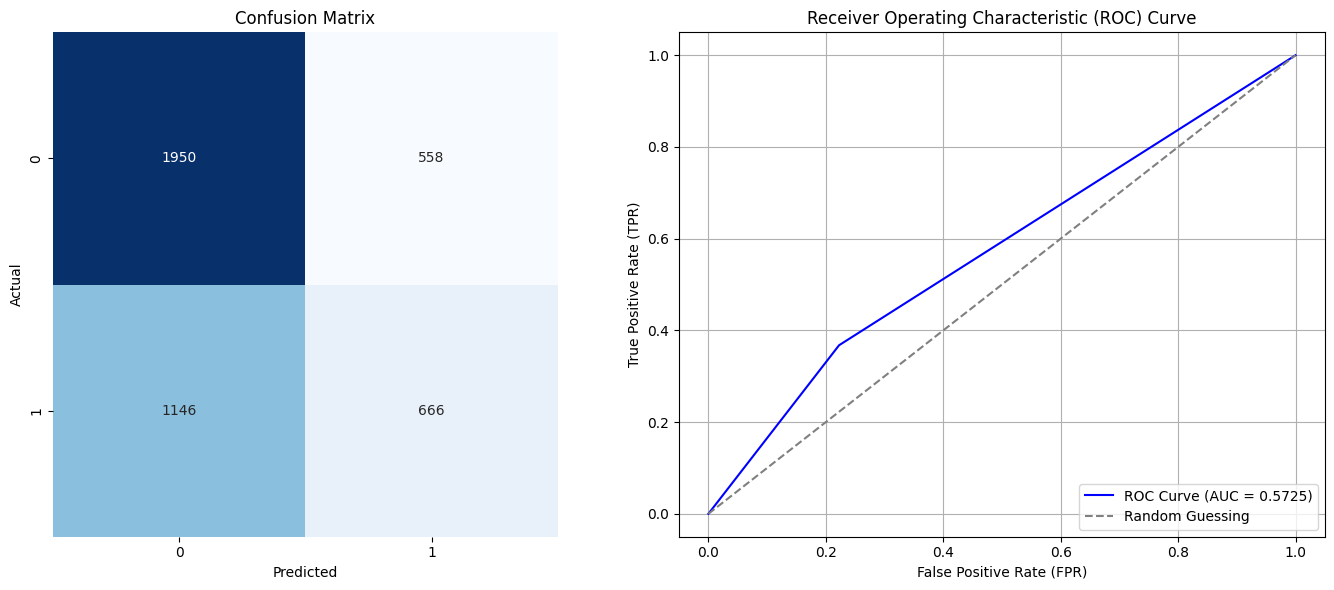

In [18]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.iloc[:,:19]

dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.iloc[:,:19]

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

acc(X_train, y_train, X_val, y_val, evaluation)

Focusing on the F1 of tweets classified as sexist

Best parameters: {'clf__C': 100, 'clf__gamma': 1}
classification report: 
               precision    recall  f1-score   support

           0       0.63      0.78      0.70      2508
           1       0.54      0.37      0.44      1812

    accuracy                           0.61      4320
   macro avg       0.59      0.57      0.57      4320
weighted avg       0.59      0.61      0.59      4320



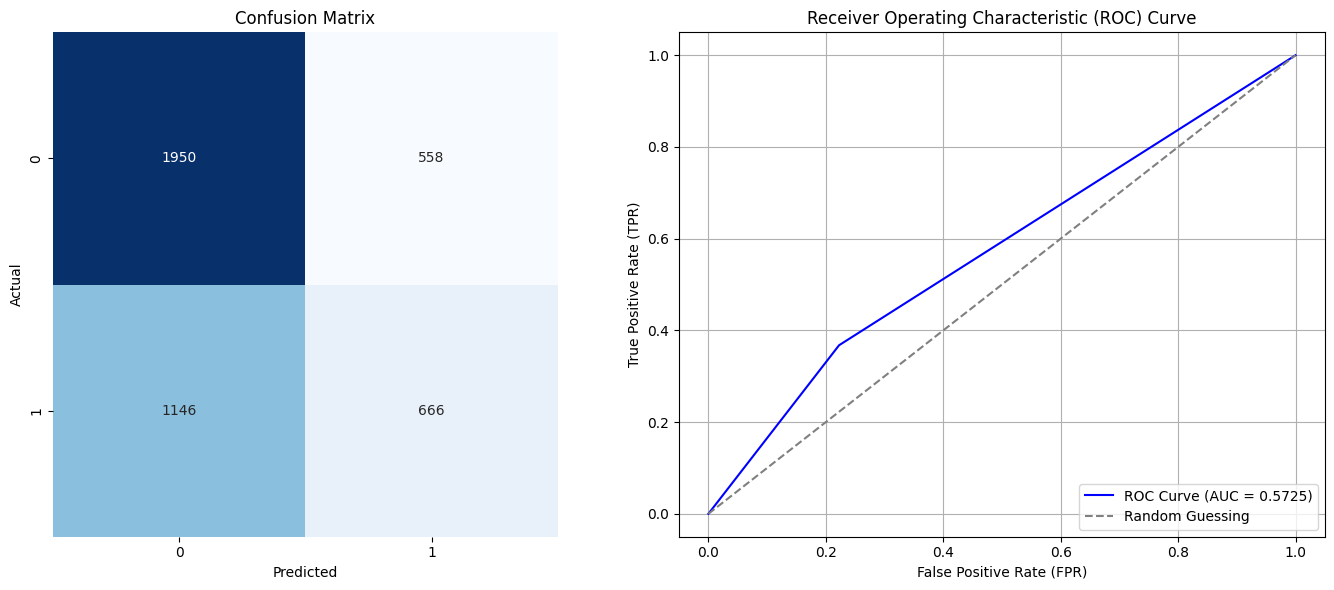

In [19]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.iloc[:,:19]

dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.iloc[:,:19]

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

f1(X_train, y_train, X_val, y_val, evaluation)

#### After Task 1 and 2

Focusing on the Accuracy

Best parameters: {'clf__C': 100, 'clf__gamma': 0.01}
classification report: 
               precision    recall  f1-score   support

           0       0.70      0.79      0.74      2508
           1       0.64      0.53      0.58      1812

    accuracy                           0.68      4320
   macro avg       0.67      0.66      0.66      4320
weighted avg       0.68      0.68      0.67      4320



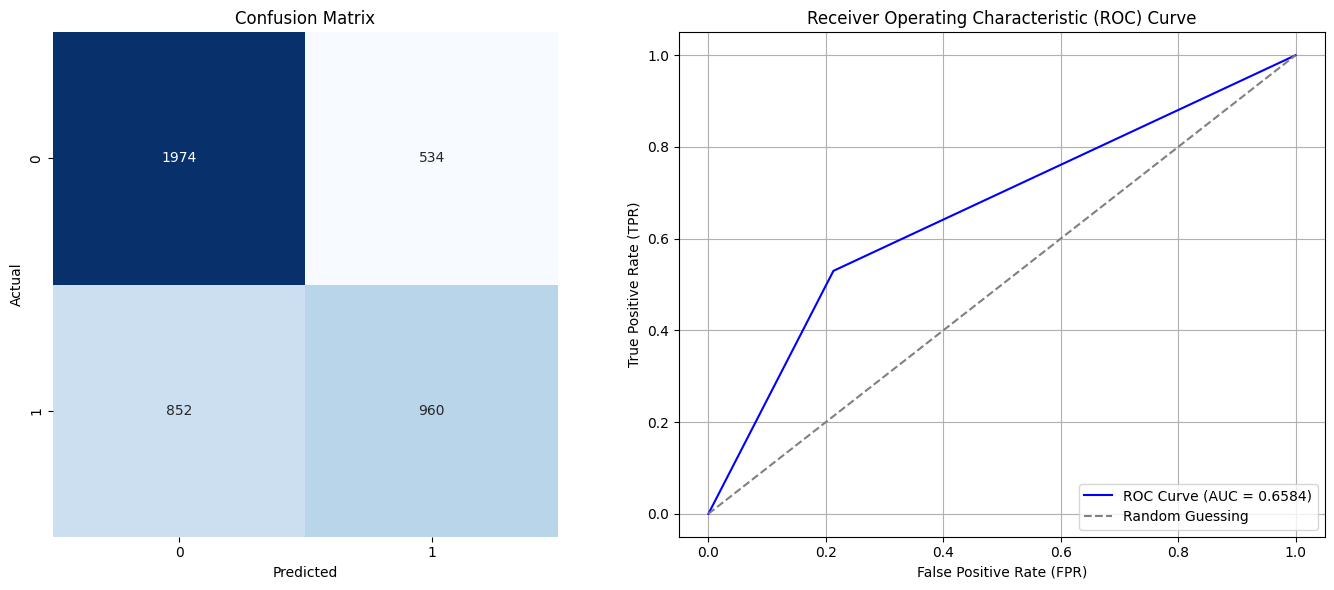

In [20]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.iloc[:,:32]
dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.iloc[:,:32]

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

acc(X_train, y_train, X_val, y_val, evaluation)

Focusing on the F1 of tweets classified as sexist

Best parameters: {'clf__C': 0.1, 'clf__gamma': 0.1}
classification report: 
               precision    recall  f1-score   support

           0       0.75      0.68      0.71      2508
           1       0.60      0.68      0.64      1812

    accuracy                           0.68      4320
   macro avg       0.68      0.68      0.68      4320
weighted avg       0.69      0.68      0.68      4320



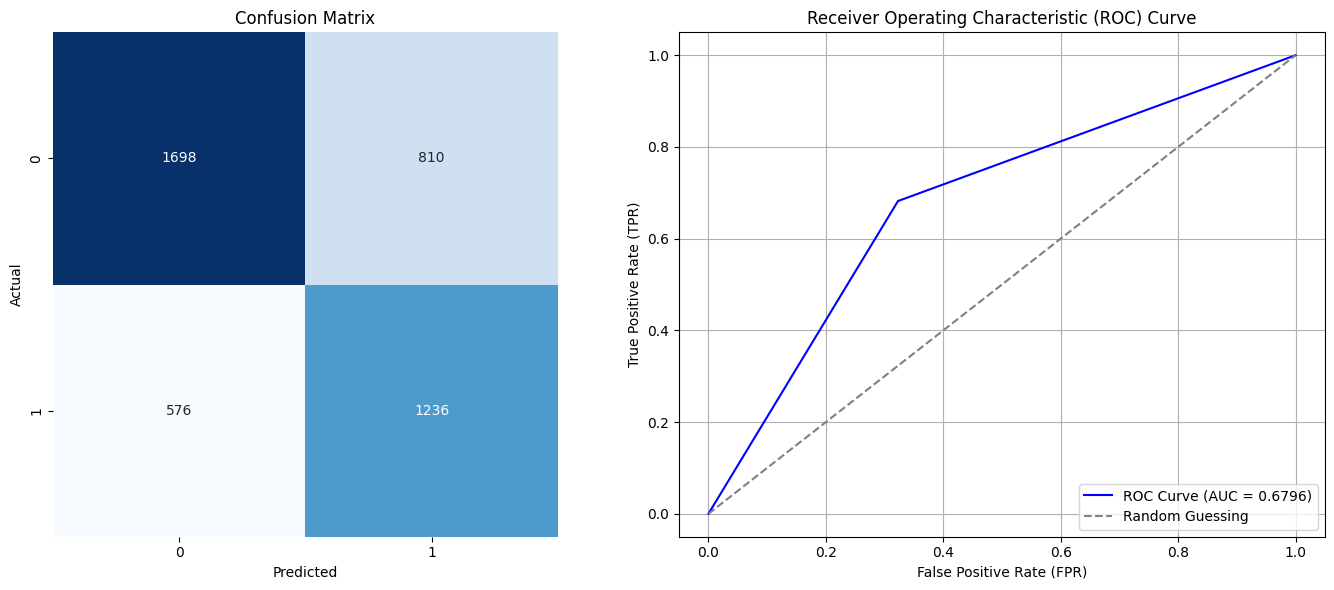

In [21]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.iloc[:,:32]
dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.iloc[:,:32]

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

f1(X_train, y_train, X_val, y_val, evaluation)

#### After Task 1 and 3

Focusing on the Accuracy

Best parameters: {'clf__C': 100, 'clf__gamma': 0.01}
classification report: 
               precision    recall  f1-score   support

           0       0.71      0.80      0.76      2508
           1       0.67      0.56      0.61      1812

    accuracy                           0.70      4320
   macro avg       0.69      0.68      0.68      4320
weighted avg       0.70      0.70      0.69      4320



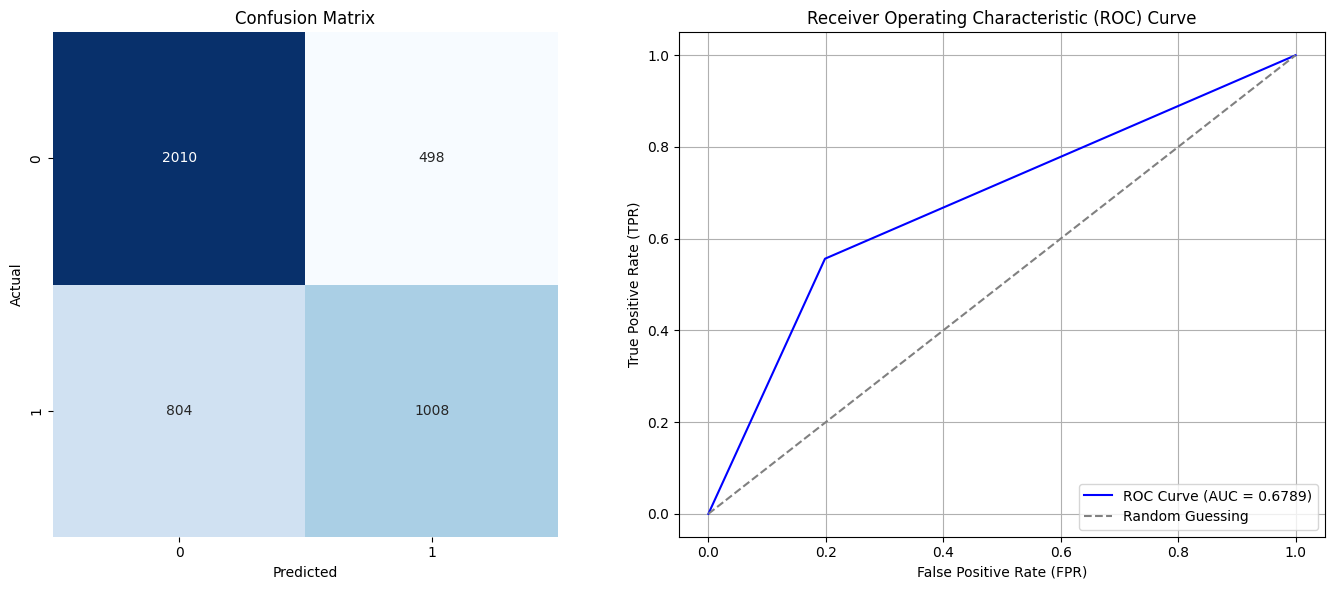

In [22]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain2 = dftrain.iloc[:,33:36]
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.iloc[:,:19]
dftrain = pd.concat([dftrain, dftrain2], axis=1)

dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval2 = dfval.iloc[:,33:36]
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.iloc[:,:19]
dfval = pd.concat([dfval, dfval2], axis=1)

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

acc(X_train, y_train, X_val, y_val, evaluation)

Focusing on the F1 of tweets classified as sexist

Best parameters: {'clf__C': 0.1, 'clf__gamma': 0.1}
classification report: 
               precision    recall  f1-score   support

           0       0.74      0.77      0.75      2508
           1       0.66      0.62      0.64      1812

    accuracy                           0.70      4320
   macro avg       0.70      0.69      0.69      4320
weighted avg       0.70      0.70      0.70      4320



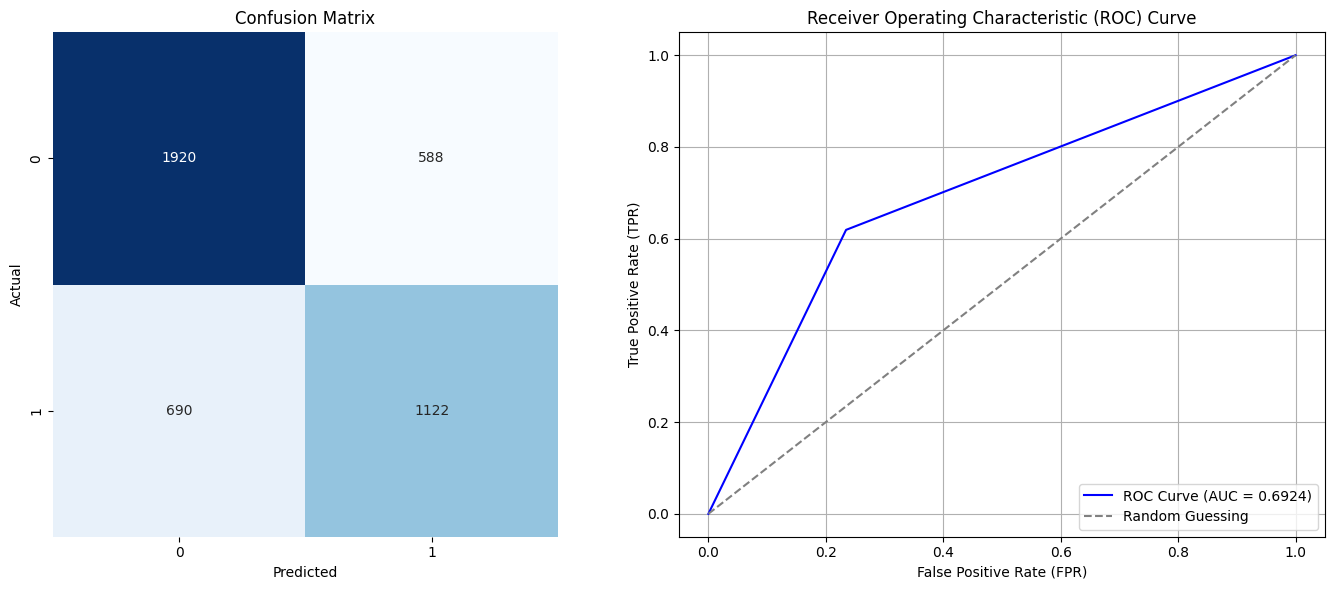

In [23]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain2 = dftrain.iloc[:,33:36]
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.iloc[:,:19]
dftrain = pd.concat([dftrain, dftrain2], axis=1)

dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval2 = dfval.iloc[:,33:36]
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.iloc[:,:19]
dfval = pd.concat([dfval, dfval2], axis=1)

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

f1(X_train, y_train, X_val, y_val, evaluation)

#### After Task 1, 2 and 3

Focusing on the Accuracy

Best parameters: {'clf__C': 10, 'clf__gamma': 0.01}
classification report: 
               precision    recall  f1-score   support

           0       0.72      0.79      0.75      2508
           1       0.67      0.57      0.62      1812

    accuracy                           0.70      4320
   macro avg       0.69      0.68      0.68      4320
weighted avg       0.70      0.70      0.70      4320



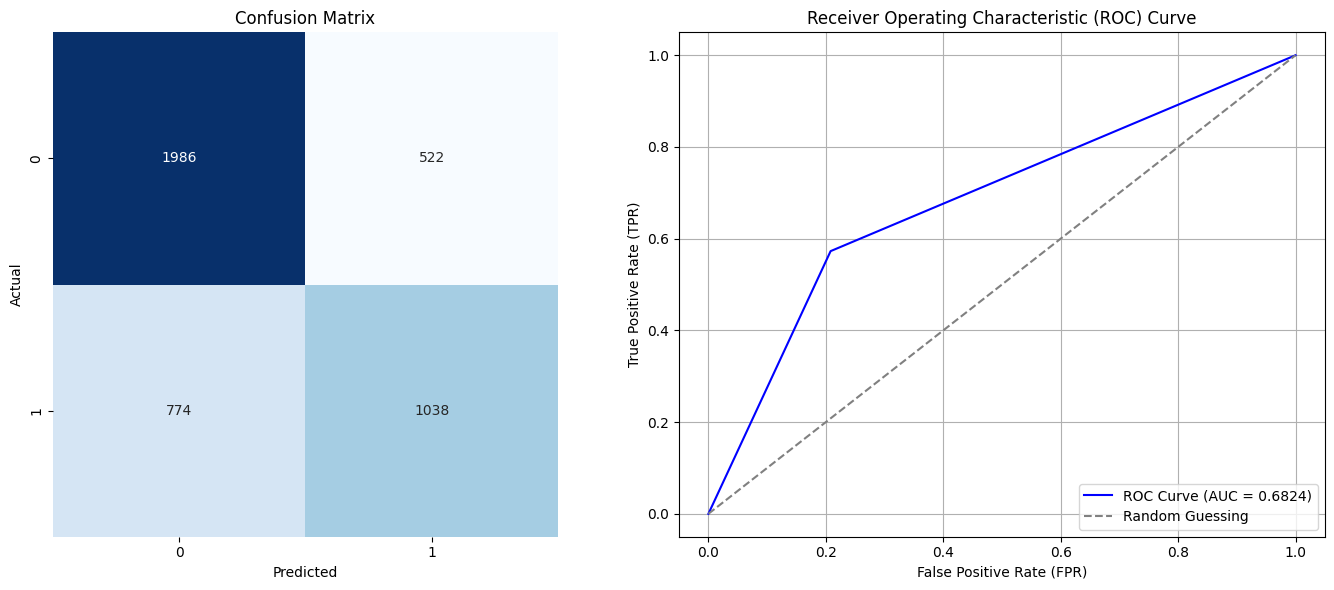

In [24]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.iloc[:,:36]
dftrain= dftrain.drop(columns='clustered_data$cluster')

dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.iloc[:,:36]
dfval= dfval.drop(columns='clustered_data$cluster')

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

acc(X_train, y_train, X_val, y_val, evaluation)

Focusing on the F1 of tweets classified as sexist

Best parameters: {'clf__C': 0.1, 'clf__gamma': 0.1}
classification report: 
               precision    recall  f1-score   support

           0       0.75      0.67      0.71      2508
           1       0.60      0.69      0.64      1812

    accuracy                           0.68      4320
   macro avg       0.68      0.68      0.67      4320
weighted avg       0.69      0.68      0.68      4320



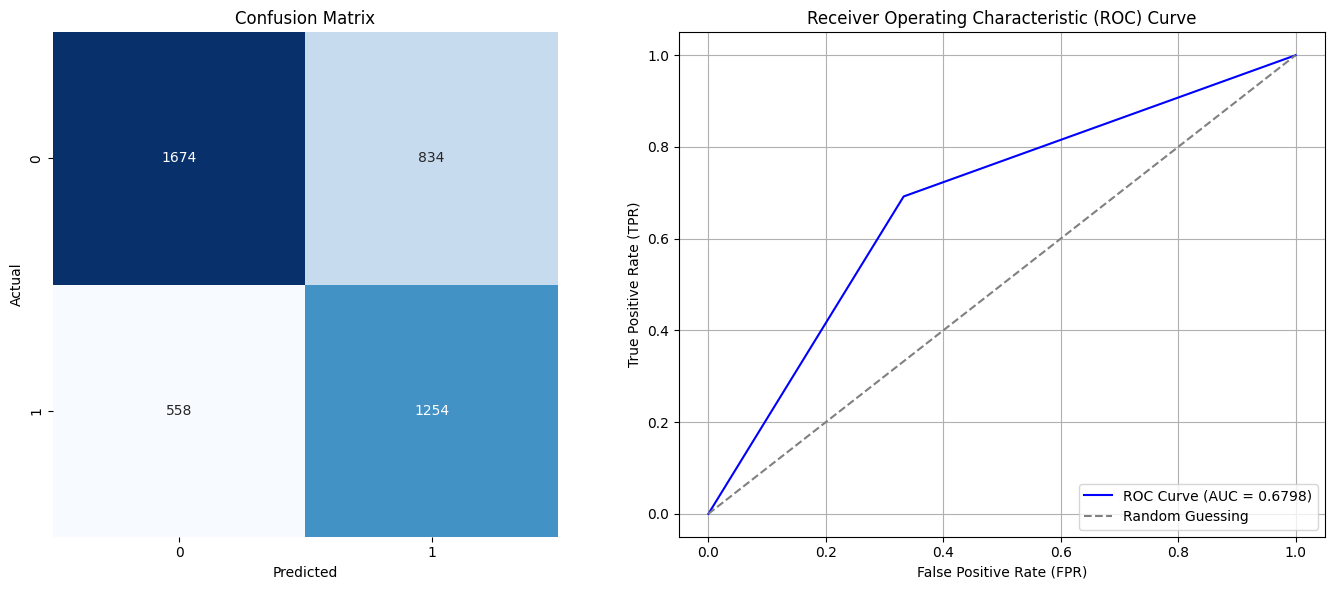

In [25]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.iloc[:,:36]
dftrain= dftrain.drop(columns='clustered_data$cluster')

dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.iloc[:,:36]
dfval= dfval.drop(columns='clustered_data$cluster')

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

f1(X_train, y_train, X_val, y_val, evaluation)

#### After Task 1, 2, 3 and 4

Focusing on the Accuracy

Best parameters: {'clf__C': 10, 'clf__gamma': 0.01}
classification report: 
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      2508
           1       0.65      0.52      0.58      1812

    accuracy                           0.68      4320
   macro avg       0.68      0.66      0.66      4320
weighted avg       0.68      0.68      0.68      4320



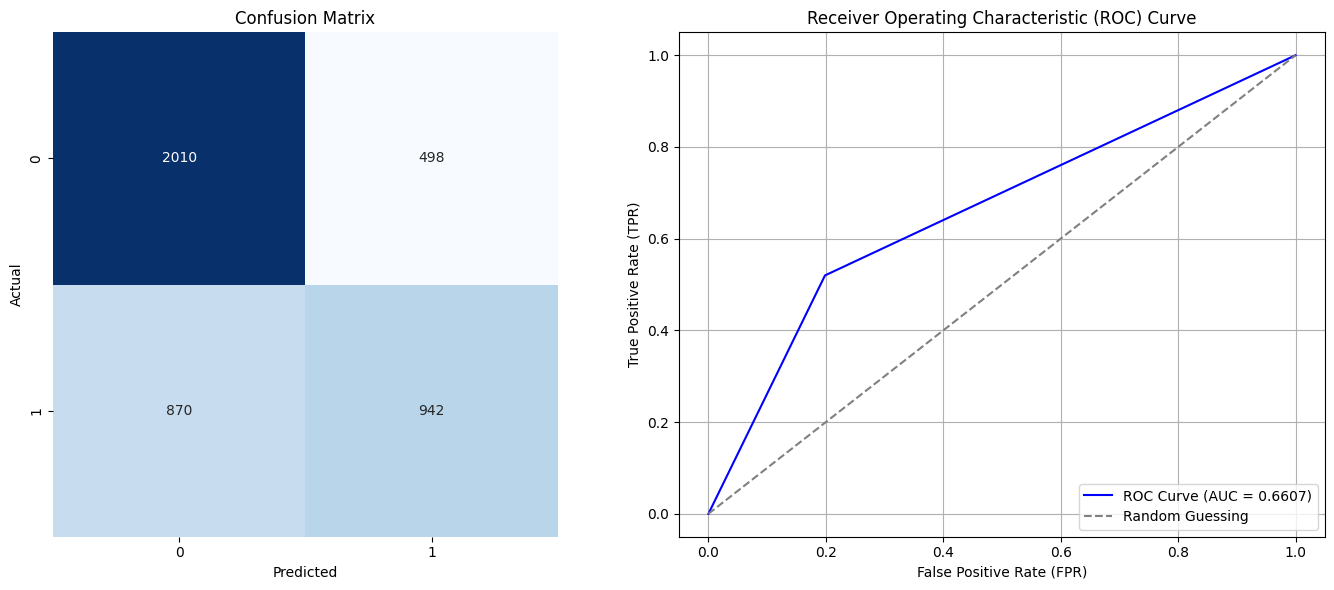

In [26]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.drop(columns='clustered_data$cluster')

dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.drop(columns=['clustered_data$cluster','profile_key'])

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

acc(X_train, y_train, X_val, y_val, evaluation)

Focusing on the F1 of tweets classified as sexist

Best parameters: {'clf__C': 0.1, 'clf__gamma': 0.1}
classification report: 
               precision    recall  f1-score   support

           0       0.75      0.65      0.70      2508
           1       0.59      0.71      0.64      1812

    accuracy                           0.67      4320
   macro avg       0.67      0.68      0.67      4320
weighted avg       0.69      0.67      0.67      4320



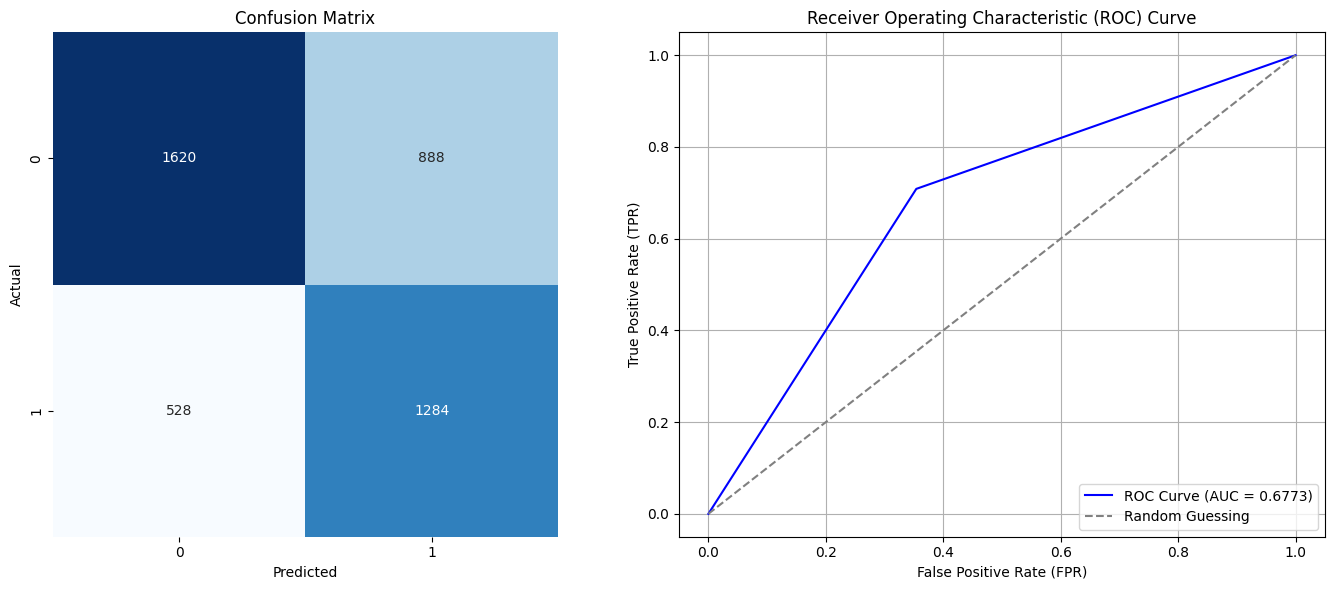

In [27]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.drop(columns='clustered_data$cluster')

dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.drop(columns=['clustered_data$cluster','profile_key'])

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

f1(X_train, y_train, X_val, y_val, evaluation)

#### After Task 1, 3 and 4

Focusing on the Accuracy

Best parameters: {'clf__C': 100, 'clf__gamma': 0.01}
classification report: 
               precision    recall  f1-score   support

           0       0.71      0.81      0.76      2508
           1       0.67      0.53      0.59      1812

    accuracy                           0.69      4320
   macro avg       0.69      0.67      0.67      4320
weighted avg       0.69      0.69      0.69      4320



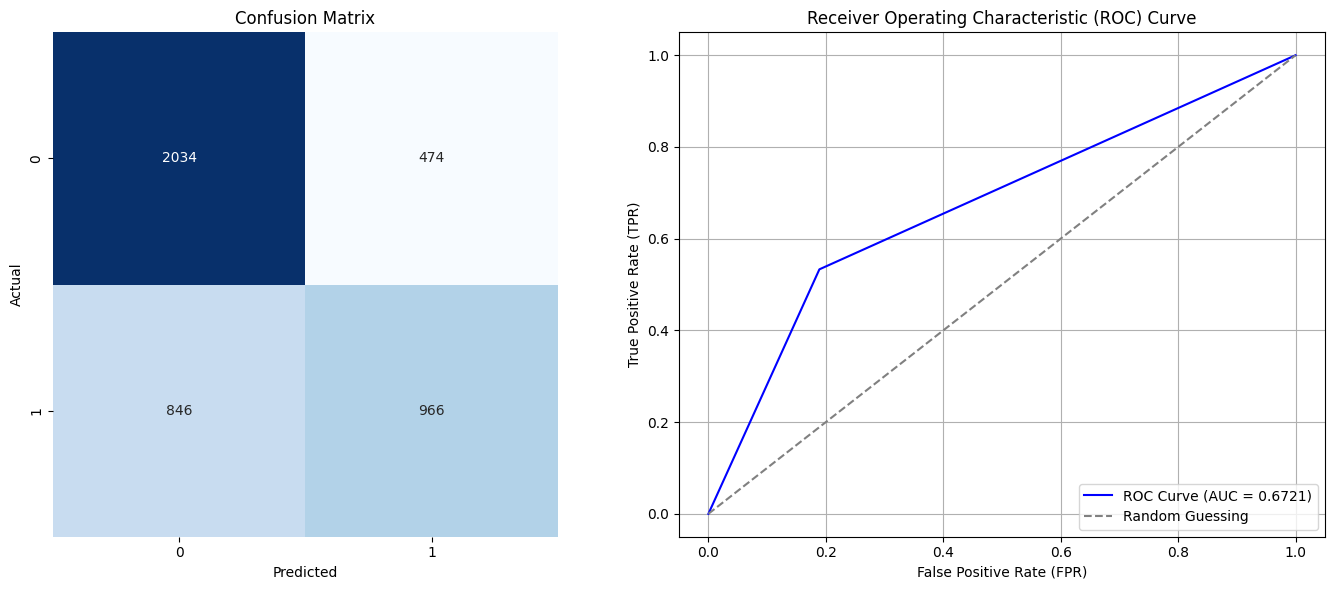

In [28]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain = dftrain.drop(dftrain.columns[19:32], axis=1)
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.drop(columns='clustered_data$cluster')

dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval = dfval.drop(dfval.columns[19:32], axis=1)
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.drop(columns=['clustered_data$cluster','profile_key'])

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

acc(X_train, y_train, X_val, y_val, evaluation)

Focusing on the F1 of tweets classified as sexist

Best parameters: {'clf__C': 0.1, 'clf__gamma': 0.1}
classification report: 
               precision    recall  f1-score   support

           0       0.74      0.76      0.75      2508
           1       0.65      0.63      0.64      1812

    accuracy                           0.70      4320
   macro avg       0.70      0.69      0.69      4320
weighted avg       0.70      0.70      0.70      4320



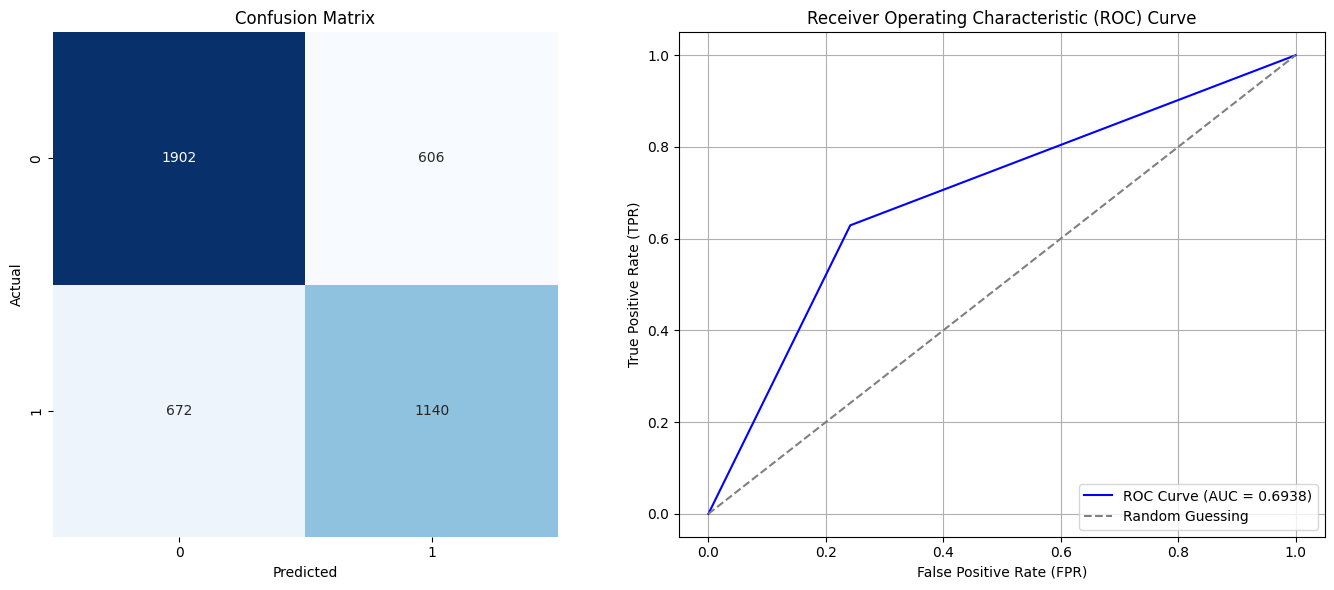

In [29]:
dftrain = pd.read_csv('tables/trainfinal.csv')
dftrain = dftrain.iloc[:, 9:]
dftrain = dftrain.drop(dftrain.columns[19:32], axis=1)
dftrain['label_task1_1']= dftrain['label_task1_1'].map({'YES':1,'NO':0})
dftrain= dftrain.drop(columns='clustered_data$cluster')

dfval = pd.read_csv('tables/valfinal.csv')
dfval = dfval.iloc[:, 9:]
dfval = dfval.drop(dfval.columns[19:32], axis=1)
dfval['label_task1_1']= dfval['label_task1_1'].map({'YES':1,'NO':0})
dfval= dfval.drop(columns=['clustered_data$cluster','profile_key'])

X_train = dftrain.drop(columns=['label_task1_1'])
y_train = dftrain['label_task1_1']
X_val = dfval.drop(columns=['label_task1_1'])
y_val = dfval['label_task1_1']

f1(X_train, y_train, X_val, y_val, evaluation)